In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# Import dataframes and analysis
In the following import the energy and weather datasets, and then we analyze the raw features given in each dataset.

In [2]:
energy_df_raw = pd.read_csv('./spain energy datasets/energy_dataset.csv')
weather_df_raw = pd.read_csv('./spain energy datasets/weather_features.csv')

## Energy dataframe analysis

Here we analyze the energy dataframe. We conclude that:
1. Since we're only forecasting demand, we do not need to know the generation sources. As a caveat, note that actually the price can affect demand, and the price is set by the generation sources, but we will ignore this aspect. Bottom-line is we will drop all columns whose labels start with `generation`.
2. By the same token, we also drop the `forecast` columns for wind and solar, as well as the `price` columns.
3. 36 rows of the dataframe have a NaN as the `total load actual` value. We will fill-in these values with the value of the week before if they are not holidays, otherwise we will fill them in with the value of the previous weekend.

In [3]:
energy_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [4]:
energy_df_raw[energy_df_raw['total load actual'].notna() == False]

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
108,2015-01-05 12:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3932.0,NaN,9258.0,23209.0,NaN,35.50,79.14
109,2015-01-05 13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4236.0,NaN,9156.0,23725.0,NaN,36.80,73.95
110,2015-01-05 14:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4215.0,NaN,9072.0,23614.0,NaN,32.50,71.93
111,2015-01-05 15:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4050.0,NaN,8779.0,22381.0,NaN,30.00,71.50
112,2015-01-05 16:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3728.0,NaN,8426.0,21371.0,NaN,30.00,71.85
113,2015-01-05 17:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3175.0,NaN,7946.0,20760.0,NaN,30.60,80.53
661,2015-01-28 13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4136.0,NaN,6223.0,36239.0,NaN,65.00,77.62
751,2015-02-01 07:00:00+01:00,449.0,312.0,0.0,4765.0,5269.0,222.0,0.0,0.0,0.0,...,208.0,0.0,3289.0,18.0,NaN,3141.0,24379.0,NaN,56.10,16.98
752,2015-02-01 08:00:00+01:00,453.0,312.0,0.0,4938.0,5652.0,288.0,0.0,0.0,0.0,...,207.0,0.0,3102.0,63.0,NaN,3165.0,27389.0,NaN,57.69,19.56
753,2015-02-01 09:00:00+01:00,452.0,302.0,0.0,4997.0,5770.0,296.0,0.0,0.0,0.0,...,204.0,0.0,2838.0,691.0,NaN,2907.0,30619.0,NaN,60.01,23.13


## Weather dataframe analysis
Here we will analyze the weather dataframe. From the analysis, we conclude the following:
1. The `city_name` feature is a categorical variable. Technically all other variables (temperatures, humidity etc.) are specific to a single city, so we will pivot the dataframe to have one row per timestamp, with weather features being also labeled by the city they were measured in. For instance, `temperature` would change to `temperature_valencia`, `temperature_madrid`, etc.
2. The `weather_main` feature is a categorical variable, so we could encode it as a one-hot vector. But it doesn't seem so relevant, so to simplify, we drop it.
3. We can drop the following features, as a priori they don't seem so relevant:
    - `temp_min` and `temp_max`
    - `clouds_all`
    - `snow_3h`
    - `weather_id`
    - `weather_description`
    - `weather_icon`

In [5]:
weather_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [6]:
weather_df_raw.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


In [7]:
weather_df_raw.head(10)

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
5,2015-01-01 05:00:00+01:00,Valencia,270.292,270.292,270.292,1004,71,2,321,0.0,0.0,0.0,0,800,clear,sky is clear,01n
6,2015-01-01 06:00:00+01:00,Valencia,270.292,270.292,270.292,1004,71,2,321,0.0,0.0,0.0,0,800,clear,sky is clear,01n
7,2015-01-01 07:00:00+01:00,Valencia,270.292,270.292,270.292,1004,71,2,321,0.0,0.0,0.0,0,800,clear,sky is clear,01n
8,2015-01-01 08:00:00+01:00,Valencia,274.601,274.601,274.601,1005,71,1,307,0.0,0.0,0.0,0,800,clear,sky is clear,01d
9,2015-01-01 09:00:00+01:00,Valencia,274.601,274.601,274.601,1005,71,1,307,0.0,0.0,0.0,0,800,clear,sky is clear,01d


It seems that in weather dataframe, all data entries are non-null 👍.

### City Analysis

Look at possible values of the `city_name` column, and check that all data entries have a city assigned.

In [8]:
print(f"Naive estimation of data entries per city: {len(weather_df_raw)/len(weather_df_raw['city_name'].unique())}")
for city in weather_df_raw['city_name'].unique():
    print(f"City: {city}, number of entries: {len(weather_df_raw[weather_df_raw['city_name'] == city])}")

# Check if all entries have a city name
assert len(weather_df_raw) == len(weather_df_raw['city_name']), 'Entries without city names found'

Naive estimation of data entries per city: 35679.2
City: Valencia, number of entries: 35145
City: Madrid, number of entries: 36267
City: Bilbao, number of entries: 35951
City:  Barcelona, number of entries: 35476
City: Seville, number of entries: 35557


### Clouds

At first not sure what the variable `clouds_all` means. After checking, it seems to be a percentage, so it possibly indicates cloudiness relative to a certain maximum.

In [9]:
for value in weather_df_raw['clouds_all'].unique():
    assert value <= 100, 'Not a percentage!'

### Weather description analysis

We look at the possible values of the `weather_main`, `weather_id`, and `weather_description` columns. We find that for each main weather type, there are several ids associated with it. Most of the times, these ids only have a singl possible description, but sometimes it can be more than one.

In [10]:
for value in weather_df_raw['weather_main'].unique():
    print(f'Main weather type: {value}')
    for id in weather_df_raw[weather_df_raw['weather_main'] == value]['weather_id'].unique():
        print(f'\tID: {id}')
        print(f'\tPossible descriptions: {weather_df_raw[weather_df_raw["weather_id"] == id]["weather_description"].unique()}')


Main weather type: clear
	ID: 800
	Possible descriptions: ['sky is clear']
Main weather type: clouds
	ID: 801
	Possible descriptions: ['few clouds']
	ID: 802
	Possible descriptions: ['scattered clouds']
	ID: 803
	Possible descriptions: ['broken clouds']
	ID: 804
	Possible descriptions: ['overcast clouds']
Main weather type: rain
	ID: 500
	Possible descriptions: ['light rain']
	ID: 501
	Possible descriptions: ['moderate rain' 'proximity moderate rain']
	ID: 502
	Possible descriptions: ['heavy intensity rain']
	ID: 522
	Possible descriptions: ['heavy intensity shower rain']
	ID: 521
	Possible descriptions: ['shower rain' 'proximity shower rain']
	ID: 503
	Possible descriptions: ['very heavy rain']
	ID: 520
	Possible descriptions: ['light intensity shower rain']
	ID: 531
	Possible descriptions: ['ragged shower rain']
Main weather type: mist
	ID: 701
	Possible descriptions: ['mist']
Main weather type: thunderstorm
	ID: 202
	Possible descriptions: ['thunderstorm with heavy rain']
	ID: 200
	

# Data processing and feature extraction

We preprocess in the following way:

1. The energy dataframe has all of its columns except those related to load dropped.
2. For the weather dataframe:
    - The columns `temp_min`, `temp_max`, `clouds_all`, `snow_3h`, `weather_main`, `weather_id`, `weather_description`and `weather_icon`are dropped.
    - Rows which repeat `city_name`and `dt_iso`(datetime) are dropped.
    - The dataframe is pivoted so that all features are subcategories of the `city_name` column. In practice this means that for every single datetime entry, there are n_c x n_w features, where there n_c is the number of cities and n_w is the number of weather features used.
3. The dataframes are concatenated on their datetime column (for the energy dataframe, this is `time`, and for the weather dataframe, this is `dt_iso`).


After this we create a transformer to transform the data into a format that can be used by the LSTM. The transformer does the following:
1. The normalizable features are normalized (using mean and standard deviation).
2. The datetime column `time` is converted into useful features, namely the year, day of the year, day of the week, hour, and also boolean features is_weekend and is_holiday. Since day of the year, day of the week and hour features are periodic, they are each transformed to corresponding sin and cos. 

Afterwards, we create a dataset class that returns the LSTM input and target variables in batches determined by the sequence length and horizon.


First we define some functions that will be useful for preprocessing the data.

In [11]:
##################################
# Dataframe preprocessing functions #
##################################

def preprocess_dfs(energy_df, weather_df):
   # Prerocesses energy_df and weather_df. Returns a dataframe with the processed data.

   # We process the energy and weather dataframes (look at the process functions for more details)
   energy_df = process_energy_df(energy_df)
   weather_df = process_weather_df(weather_df)
   
   # We merge the energy and weather dataframes on the energy_df time column.capitalize.
   # We first check that the energy and weather dataframes have the same length.
   assert len(energy_df) == len(weather_df), 'The energy and weather dataframes have different lengths'
   result = pd.concat([energy_df, weather_df[weather_df['dt_iso'].isin(energy_df['time'])]], axis = 1)
   
   return result.drop(columns = ['dt_iso'])

def process_energy_df(energy_df):
   # We drop the columns that are not relevant for the prediction
   dropped_cols = energy_df.columns
   dropped_cols = [x for x in dropped_cols if x.split(' ')[0] in ['generation', 'forecast', 'price']]
   
   energy_df['total load actual'].fillna(energy_df['total load forecast'], inplace = True)

   return energy_df.drop(columns = dropped_cols)

   

def process_weather_df(weather_df):
   
   # We drop the columns that are not relevant for the prediction
   weather_df = weather_df.drop(columns = ['temp_min', 'temp_max','clouds_all', 'snow_3h',
                'weather_id', 'weather_description','weather_icon', 'weather_main'])
   # There are duplicates in date and city, so we drop them
   weather_df = weather_df.drop_duplicates(subset = ['dt_iso', 'city_name'])

   # Now we pivot the dataframe with respect to the city_name label
   weather_df = weather_df.pivot(index = 'dt_iso', columns = 'city_name', 
            values = [col for col in weather_df.columns if col not in ['dt_iso', 'city_name']])

   # We rename the columns to recover a 2D tensor structure
   weather_df.columns = [f'{var}_{col}' for var, col in weather_df.columns]
   weather_df = weather_df.reset_index()

   
   return weather_df



In [12]:
processed_df = preprocess_dfs(energy_df_raw, weather_df_raw)
processed_df.head()

,time,total load forecast,total load actual,temp_ Barcelona,temp_Bilbao,temp_Madrid,temp_Seville,temp_Valencia,pressure_ Barcelona,pressure_Bilbao,...,rain_1h_ Barcelona,rain_1h_Bilbao,rain_1h_Madrid,rain_1h_Seville,rain_1h_Valencia,rain_3h_ Barcelona,rain_3h_Bilbao,rain_3h_Madrid,rain_3h_Seville,rain_3h_Valencia
0,2015-01-01 00:00:00+01:00,26118.0,25385.0,281.625,269.657312,267.325,273.375,270.475,1035.0,1036.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 01:00:00+01:00,24934.0,24382.0,281.625,269.763500,267.325,273.375,270.475,1035.0,1035.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 02:00:00+01:00,23515.0,22734.0,281.286,269.251688,266.186,274.086,269.686,1036.0,1036.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 03:00:00+01:00,22642.0,21286.0,281.286,269.203344,266.186,274.086,269.686,1036.0,1035.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 04:00:00+01:00,21785.0,20264.0,281.286,269.485500,266.186,274.086,269.686,1036.0,1035.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the following we create the transform `transform_features` which normalizes float features, one hot encodes categorical features and creates dummy variables for the periodic features implicit the `time` column.

In [13]:
class transform_features:
    def __init__(self, cat_columns = None, norm_columns = None, means = None, stds = None):
        # The following, once updated, are arrays containing the names of the features that are normalizable,
        # and the means and standard deviations of the normalizable features. Indices of the means and stds should
        # match the corresponding index in the norm_columns array.
        self.cat_columns = cat_columns

        self.norm_columns = norm_columns
        self.means = means
        self.stds = stds

        # The following lists words that appear in normalizable feature names, which may be used to update
        self.normalizable_prefixes = ['total load actual', 'temp', 'pressure', 'humidity', 
                                        'wind', 'rain','snow','clouds']
        self.categorical_prefixes = ['weather']


    def update(self, df):
        self.cat_columns = [col for col in df.columns if any(prefix in col for prefix in self.categorical_prefixes)]
        self.norm_columns = [col for col in df.columns if any(prefix in col for prefix in self.normalizable_prefixes)]
        self.means = df[self.norm_columns].mean(axis = 0)
        self.stds = df[self.norm_columns].std(axis = 0)



    def __call__(self, df):
        assert type(df) == pd.DataFrame, 'df should be a pandas DataFrame'

        cat_columns_in_df = [col for col in df.columns if col in self.cat_columns]
        norm_columns_in_df = [col for col in df.columns if col in self.norm_columns]
        
        
        # One-hot encode categorical features
        if len(cat_columns_in_df) > 0:
            df = pd.get_dummies(df, columns = cat_columns_in_df, dtype = float)
        
        # Normalize features
        if len(norm_columns_in_df) > 0:
            df[norm_columns_in_df] = (df[norm_columns_in_df] - self.means[norm_columns_in_df]) / self.stds[norm_columns_in_df]
        

        # Extract datetime features in a format useful for training
        if 'time' in df.columns:
            datetime_features = extract_datetime_features(df['time'])
            df = pd.concat([df, datetime_features], axis = 1).drop(columns = 'time')
        
        return df
        

##############################################
# Some functions to handle datetime features #
##############################################

def to_periodic(series, period):
   # Returns the cosine and sine of the series
   label = series.name
   cos_series = series.copy().apply(lambda x: np.cos(2 * np.pi * x / period))
   cos_series.name = f'{label}_cos'
   sin_series = series.copy().apply(lambda x: np.sin(2 * np.pi * x / period))
   sin_series.name = f'{label}_sin'

   return cos_series, sin_series


def extract_datetime_features(series, holidays = None, norm_year = 2015):
   # This function does the following:
   # - Extracts the year, day of year, day of week and hour from the series
   # - Year is standardized with respect to norm_year
   # - For periodic features (day of the year, day of the week, hour) returns cosine and sine of the series
   # - If holidays is not None, it returns a binary series indicating if the date is a holiday.
   # - Also returns whether the date is a weekend or not
   # - Returns a pandas dataframe with the extracted features in the order:
   #  [year, day_of_year_cos, day_of_year_sin, is_holiday, day_of_week_cos, day_of_week_sin, 
   #   is_weekend, hour_cos, hour_sin]
   
   series = pd.to_datetime(series, utc = True)

   year_series = series.dt.isocalendar().year.astype(float)/norm_year - 1.0
   year_series.name = 'year'

   day_of_y_series = series.dt.dayofyear
   day_of_y_series.name = 'day_of_year'
   day_of_y_cos, day_of_y_sin = to_periodic(day_of_y_series, 365)
   holidays = [x.timetuple().tm_yday for x in holidays] if holidays is not None else []

   is_holiday = day_of_y_series.isin(holidays).astype(float)
   is_holiday.name = 'is_holiday'

   day_of_w_series = series.dt.isocalendar().day
   day_of_w_series.name = 'day_of_week'
   is_weekend = series.dt.isocalendar().day.isin([6, 7]).astype(float)
   is_weekend.name = 'is_weekend'
   day_of_w_cos, day_of_w_sin = to_periodic(day_of_w_series, 7)

   hour_series = series.dt.hour
   hour_series.name = 'hour'
   hour_cos, hour_sin = to_periodic(hour_series, 24)

   return pd.concat([year_series, day_of_y_cos, day_of_y_sin, is_holiday, day_of_w_cos, day_of_w_sin, is_weekend, hour_cos, hour_sin], axis=1)



class LSTMTimeSeriesDataset(Dataset):
    def __init__(self, df, transform, seq_length = 24, horizon = 24):
        self.df = df
        self.transform = transform
        self.seq_length = seq_length
        self.horizon = horizon
        self.length = len(df) - seq_length - horizon
        
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        
        X_df = self.df.drop(columns = ['total load forecast']).iloc[idx:idx + self.seq_length]
        Y_df = self.df[['total load actual']].iloc[idx + self.seq_length:idx + self.seq_length + self.horizon]

        X = self.transform(X_df).astype(float).values
        Y = self.transform(Y_df).astype(float).values
        
        return torch.tensor(X, dtype = torch.float32), torch.tensor(Y, dtype = torch.float32)
    
    

In [14]:
transform = transform_features()
transform.update(processed_df)
energy_ds = LSTMTimeSeriesDataset(processed_df, transform)
x_test, y_test = energy_ds[0]

print(x_test.shape)
print(y_test.shape)

torch.Size([24, 45])
torch.Size([24, 1])


## Create Training dataset

In [15]:
train_ratio = 0.1
n_train = int(train_ratio * len(energy_ds))

train_dataset = LSTMTimeSeriesDataset(processed_df[:n_train], transform)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

## Create LSTM model

In [16]:
n_features = train_dataset[0][0].shape[1]


class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]).reshape(-1,24,1)
        return out

model = CustomLSTM(n_features, hidden_size = 64, output_size = 24)

In [17]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")


else:
    print('MPS device found.')

MPS device found.


TypeError: 'float' object is not iterable

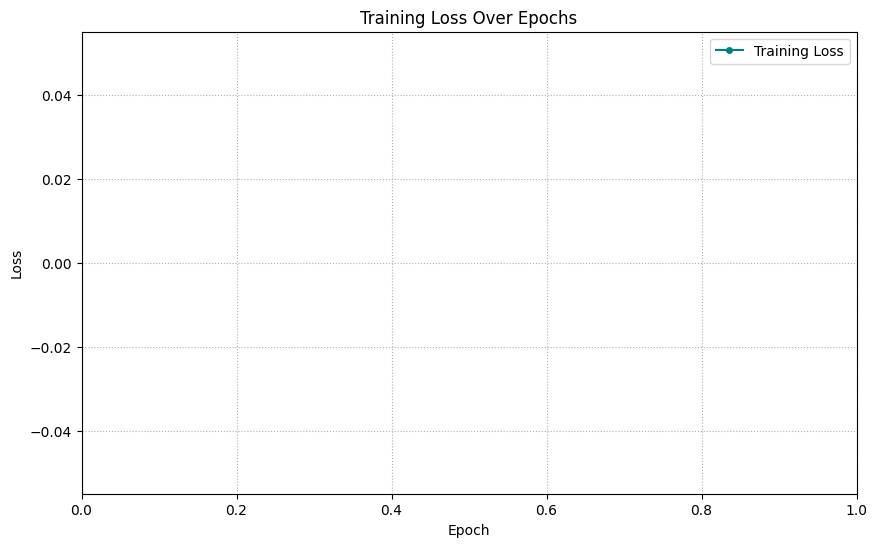

In [18]:
# Identify training device and move model to device
device = torch.device("cpu")
model  = model.to(device)


# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=10**(-2))

# Training loop
epochs = 30


plt.ion()

fig, ax = plt.subplots(figsize=(10, 6))

# Initialize training and validation curves
line_train, = ax.plot([], [], label='Training Loss', color='teal', marker='o', markersize=4, linestyle='-')

# Set plot titles and labels
ax.set_title('Training Loss Over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, linestyle=':')


train_loss_list = []
epoch_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    
            
    epoch_list.append(epoch)
    train_loss_list.append(train_loss/len(train_loader))
    
    
    # Update plot data and redraw
    line_train.set_data(epoch_list, train_loss_list)

    ax.set_xlim(0, epoch  + 1)
    ax.set_ylim(min(min(train_loss_list)) * 0.9, max(max(train_loss_list)) * 1.1)

    
    
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss/len(train_loader):.4f}")
    
plt.ioff() 
plt.show()    

dfd

In [15]:

test = pd.DataFrame({'a': [1,2,np.nan,4,np.nan], 'b': [5,4,3,2,1]})

test['a'].fillna(test['a'].shift(1),inplace = True)

test




,a,b
0,1.0,5
1,2.0,4
2,2.0,3
3,4.0,2
4,4.0,1


In [ ]:
# Here we write the national holidays that are fixed, hence Good Friday is not included.
# In addition, each region has its own extra holidays, but we will not consider this complication here.
spanish_national_holidays = [
    "January 1",
    "January 6",
    "May 1",
    "August 15",
    "November 1",
    "December 6",
    "December 8",
    "December 25"
]